<a href="https://colab.research.google.com/github/ellie456789/STA365HW/blob/main/HW6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Question 1


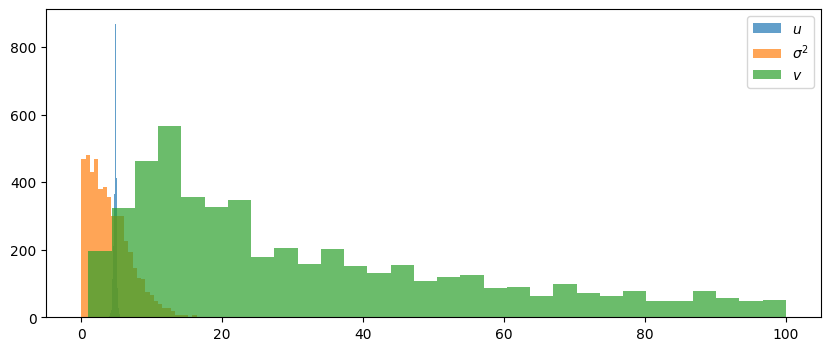

In [17]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

# Posterior w/ log
def log_posterior(u, sigma2, v, x):
    n = len(x)

    # Prior for u
    log_prior_u = -0.5 * tau0 * (u - u0) ** 2

    # Prior for sigma2
    log_prior_sigma2 = -0.5 * (sigma2 ** 2) / sigma0 ** 2

    # Prior for v
    log_prior_v = -np.log(100) if 1 <= v <= 100 else -np.inf

    # likelihood
    log_likelihood = np.sum(stats.t.logpdf(x, df=v, loc=u, scale=np.sqrt(sigma2)))

    return log_likelihood + log_prior_u + log_prior_sigma2 + log_prior_v

# MH for v -> log
def metropolis_update_v(current_v, u, sigma2, x):
    proposal_v = np.random.choice(np.arange(1, 101))  # Propose a new v from {1, ..., 100}
    log_alpha = log_posterior(u, sigma2, proposal_v, x) - log_posterior(u, sigma2, current_v, x)

    if np.log(np.random.rand()) < log_alpha:
        return proposal_v  # Accept
    else:
        return current_v  # Reject

# Gibbs Sampler Implementation
def gibbs_sampler(n_samples, x):
    n = len(x)
    u_samples = np.zeros(n_samples)
    sigma2_samples = np.zeros(n_samples)
    v_samples = np.zeros(n_samples)

    # Initialize parameters
    u = np.mean(x)
    sigma2 = np.var(x)
    v = np.random.choice(np.arange(1, 101))  # Initialize v randomly

    for i in range(n_samples):
        u_var = 1 / (tau0 + n / sigma2)
        u_mean = u_var * (tau0 * u0 + np.sum(x) / sigma2)
        u = np.random.normal(u_mean, np.sqrt(u_var))


        sigma2 = abs(np.random.normal(scale=sigma0))

        v = metropolis_update_v(v, u, sigma2, x)

        # Store samples
        u_samples[i] = u
        sigma2_samples[i] = sigma2
        v_samples[i] = v

    return u_samples, sigma2_samples, v_samples

# run
np.random.seed(42)
x = stats.t.rvs(df=10, loc=5, scale=2, size=100)

u0, tau0 = 3, 1
sigma0 = 5
n_samples = 5000
u_samples, sigma2_samples, v_samples = gibbs_sampler(n_samples, x)

# Plot results
plt.figure(figsize=(10, 4))
plt.hist(u_samples, bins=30, alpha=0.7, label=r'$u$')
plt.hist(sigma2_samples, bins=30, alpha=0.7, label=r'$\sigma^2$')
plt.hist(v_samples, bins=30, alpha=0.7, label=r'$v$')
plt.legend()
plt.show()


Question 2


Output()

ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Output()

ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Output()

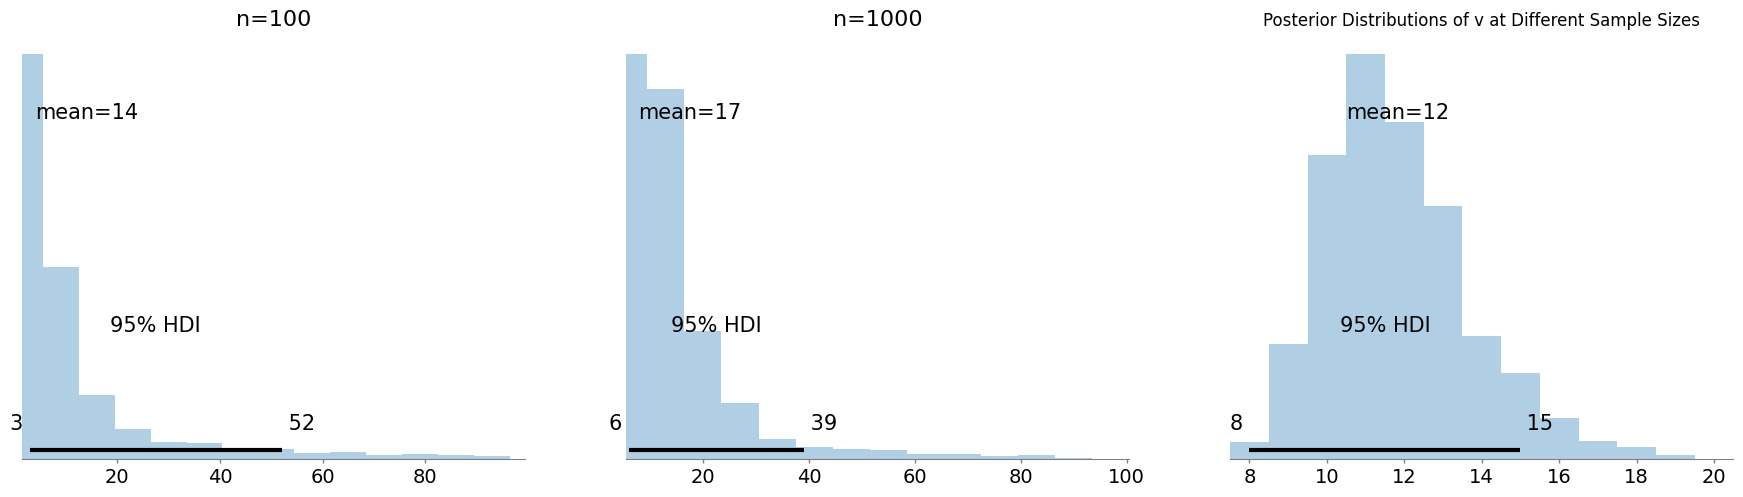

R-hat for n=100:
 v    1.02
Name: r_hat, dtype: float64
R-hat for n=1000:
 v    1.03
Name: r_hat, dtype: float64
R-hat for n=5000:
 v    1.01
Name: r_hat, dtype: float64

Posterior Summary for n=100:
     mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
v  14.14  16.15     3.0     48.0       1.68     1.19    157.59    116.79   

   r_hat  
v   1.02  

Posterior Summary for n=1000:
     mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
v  17.41  11.77     6.0     35.0        0.9     0.64    191.83    263.09   

   r_hat  
v   1.03  

Posterior Summary for n=5000:
     mean   sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  r_hat
v  11.82  1.9     9.0     15.0       0.11     0.08    312.12    527.27   1.01


In [21]:
import pymc as pm
import matplotlib.pyplot as plt
import numpy as np
import arviz as az

# Bayesian inference for different sample sizes
def pymc_inference(n_samples):
    np.random.seed(42)

    # Generate synthetic data from a Student's t-distribution
    true_u = 5
    true_sigma = 2
    true_v = 10  # True degrees of freedom
    x = np.random.standard_t(df=true_v, size=n_samples) * true_sigma + true_u

    # Define Bayesian Model

    with pm.Model() as model:
        # Priors
        u = pm.Normal("u", mu=5, sigma=1)  # Normal prior for mean
        sigma = pm.HalfNormal("sigma", sigma=2)  # Half-Normal prior for variance
        v = pm.DiscreteUniform("v", lower=1, upper=100)  # Discrete uniform prior for degrees of freedom

        # Likelihood
        likelihood = pm.StudentT("obs", nu=v, mu=u, sigma=sigma, observed=x)

        # MCMC Sampling using NUTS
        trace = pm.sample(2000, return_inferencedata=True, cores=2)

    return trace

# Run  for different sample sizes
trace_100 = pymc_inference(100)   # Small sample size
trace_1000 = pymc_inference(1000)   # Medium sample size
trace_5000 = pymc_inference(5000) # Large sample size

# posterior distributions of v
az.plot_posterior(
    {"n=100": trace_100.posterior["v"], "n=1000": trace_1000.posterior["v"], "n=5000": trace_5000.posterior["v"]},
    hdi_prob=0.95
)
plt.title("Posterior Distributions of v at Different Sample Sizes")
plt.show()

#checking $R
print("R-hat for n=100:\n", az.summary(trace_100, var_names=["v"])["r_hat"])
print("R-hat for n=1000:\n", az.summary(trace_1000, var_names=["v"])["r_hat"])
print("R-hat for n=5000:\n", az.summary(trace_5000, var_names=["v"])["r_hat"])

# Summary of posterior distributions
summary_100 = az.summary(trace_100, var_names=["v"], round_to=2)
summary_1000 = az.summary(trace_1000, var_names=["v"], round_to=2)
summary_5000 = az.summary(trace_5000, var_names=["v"], round_to=2)

print("\nPosterior Summary for n=100:\n", summary_100)
print("\nPosterior Summary for n=1000:\n", summary_1000)
print("\nPosterior Summary for n=5000:\n", summary_5000)



it shows that larger sampler size ensures less uncertanity for v

Question 3
$$
P(\tau_i) = Gamma (\tau_i | \alpha = v/2, \beta = v/2) \\
P(y_i|\tau_i) = N(y_i|0, \tau_i^-1)\\
$$
integral with tau:
$$
p(y_i) = \int P(y_i|\tau_i) P(\tau_i) d \tau_i
$$
which result in t-distribution
$$
y_i = t_v(0,1)
$$